<a href="https://colab.research.google.com/github/kevinwjin/pytorch-intro/blob/main/pytorchIntro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize, Compose
import os
import matplotlib.pyplot as plt
import numpy as np

In [56]:
A = [[6, 9, 2],
     [3, 3, 7],
     [1, 0, 3]]
A_tensor = torch.tensor(A)
A

[[6, 9, 2], [3, 3, 7], [1, 0, 3]]

In [57]:
B = np.array([0, 1, 2, 3])
B_tensor = torch.from_numpy(B)
B

array([0, 1, 2, 3])

In [58]:
C = torch.zeros(4, 4)
C

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [59]:
D = torch.ones(3, 3, 2, dtype = torch.int)
D

tensor([[[1, 1],
         [1, 1],
         [1, 1]],

        [[1, 1],
         [1, 1],
         [1, 1]],

        [[1, 1],
         [1, 1],
         [1, 1]]], dtype=torch.int32)

In [60]:
A_tensor_zeros = torch.zeros_like(A_tensor)
A_tensor_zeros

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])

In [61]:
# the dtype argument allows you to explicitly specify the datatype of the tensor
A_tensor_rand = torch.rand_like(A_tensor, dtype = torch.float)
A_tensor_rand

tensor([[0.3478, 0.4409, 0.9035],
        [0.3793, 0.6929, 0.5623],
        [0.9174, 0.7243, 0.4143]])

In [62]:
A_tensor_rand.dtype
A_tensor_rand.shape
A_tensor_rand.device

device(type='cpu')

In [63]:
# True if a GPU (instead of CPU) is available to train on
torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [64]:
# Train image model on CIFAR10 dataset
# Define transform function; normalize images
transform = Compose(
    [ToTensor(),
     Normalize((0.5, 0.5, 0.5),  # mean
               (0.5, 0.5, 0.5))] # standard deviation
)

In [65]:
training_data = CIFAR10(root = "cifar",
                        train = True, # training set, 50k images
                        download = True,
                        transform = transform)

test_data = CIFAR10(root = "cifar",
                    train = False, # test set, 10k images
                    download = True,
                    transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [66]:
# Prepare to feed dataset into neural network using DataLoader iterator
batch_size = 4
train_dataloader = DataLoader(training_data,
                              batch_size = batch_size,
                              shuffle = True)

test_dataloader = DataLoader(test_data,
                             batch_size = batch_size,
                             shuffle = True)

In [67]:
# Check dimensions of one iteration
for X, y in train_dataloader:
  print(f'Shape of X [N, C, H, W]: {X.shape}')
  print(f'Shape of y: {y.shape} {y.dtype}')
  break

# Each iteration through train_dataloader is a mini-batch of 
# four 32x32 images and their 4 corresponding labels.

Shape of X [N, C, H, W]: torch.Size([4, 3, 32, 32])
Shape of y: torch.Size([4]) torch.int64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


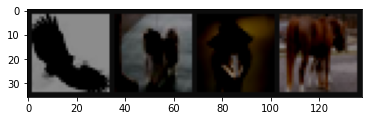

bird  dog   bird  horse


In [68]:
# Display a few images in the training set
def imshow(img):
  img = img / 2 + 0.05 # revert normalization for viewing
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

classes = training_data.classes
training_data.classes

dataiter = iter(train_dataloader)
images, labels = dataiter.next()
imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [69]:
# Build neural network: Define the base model
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.flatten = nn.Flatten() # transform 3D tensor into 1D array
    self.linear_relu_stack = nn.Sequential( # hidden layers
        nn.Linear(32*32*3, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits
    
model = NeuralNetwork().to(device) # attach neural network to CUDA
print(model) # summary of structure

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [70]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD( model.parameters(), lr = 0.001 ) # momentum = 0.9

In [71]:
# Define the training loop
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train() # set model to training mode
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)
    # Backpropagation
    optimizer.zero_grad()
    loss.backward() # loss = penalty for a bad prediction
    optimizer.step()
    if batch % 2000 == 0: # print computed loss every 2000 training samples
      loss, current = loss.item(), batch * len(X)
      print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')

In [72]:
# Define the test function to evaluate the model after every epoch
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval() # set model to testing mode
  test_loss, correct = 0, 0
  with torch.no_grad():  # Disable gradient calculation
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f'Test Error: \n Accuracy : {(100 * correct):>0.1f}%, Avg Loss: {test_loss:>8f} \n')

In [73]:
# Train the model
epochs = 10
for t in range(epochs):
  print(f'Epoch {t+1}\n---------------------------------')
  train(train_dataloader, model, loss_fn, optimizer)
  test(test_dataloader, model, loss_fn)
print('Done!')

Epoch 1
---------------------------------
loss: 2.331644 [    0/50000]
loss: 2.120354 [ 8000/50000]
loss: 2.351751 [16000/50000]
loss: 1.998426 [24000/50000]
loss: 2.128920 [32000/50000]
loss: 1.594628 [40000/50000]
loss: 1.469181 [48000/50000]
Test Error: 
 Accuracy : 39.3%, Avg Loss: 1.716132 

Epoch 2
---------------------------------
loss: 2.328233 [    0/50000]
loss: 1.482545 [ 8000/50000]
loss: 1.587057 [16000/50000]
loss: 0.882040 [24000/50000]
loss: 2.373311 [32000/50000]
loss: 2.033620 [40000/50000]
loss: 1.300619 [48000/50000]
Test Error: 
 Accuracy : 45.3%, Avg Loss: 1.573553 

Epoch 3
---------------------------------
loss: 1.171744 [    0/50000]
loss: 0.961821 [ 8000/50000]
loss: 1.673367 [16000/50000]
loss: 0.715818 [24000/50000]
loss: 1.205686 [32000/50000]
loss: 1.785862 [40000/50000]
loss: 1.186280 [48000/50000]
Test Error: 
 Accuracy : 47.4%, Avg Loss: 1.493065 

Epoch 4
---------------------------------
loss: 1.514398 [    0/50000]
loss: 1.070111 [ 8000/50000]
loss: 

In [74]:
# Save the model
torch.save(model.state_dict(), "cifar_fc.pth")

In [75]:
# Load thde model for inference
model = NeuralNetwork()
model.load_state_dict(torch.load("cifar_fc.pth"))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


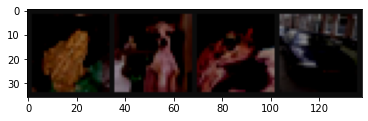

Ground Truth:  frog  dog   frog  automobile
Predicted:  frog  dog   truck automobile


In [81]:
# Evaluate the model
dataiter = iter(test_dataloader)
images, labels = dataiter.next()
# Load a sample of images with their labels
imshow(make_grid(images))
print('Ground Truth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
# Compare to model's predicted labels
outputs = model(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

In [79]:
# Run the numbers on model performance
correct = 0
total = 0

with torch.no_grad():
  for data in test_dataloader:
    images, labels = data
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f'Model accuracy: {100 * correct // total}%')

Model accuracy: 54%


In [82]:
# Check how model performed on each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0  for classname in classes}

with torch.no_grad():
  for data in test_dataloader:
    images, labels = data
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    for label,prediction in zip(labels, predictions):
      if label == prediction:
        correct_pred[classes[label]] += 1
      total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
  accuracy = 100 * float(correct_count) / total_pred[classname]
  print(f'Accuracy for class {classname:5s}: {accuracy:.1f}%')

Accuracy for class airplane: 59.1%
Accuracy for class automobile: 69.0%
Accuracy for class bird : 46.2%
Accuracy for class cat  : 31.7%
Accuracy for class deer : 43.5%
Accuracy for class dog  : 42.2%
Accuracy for class frog : 61.4%
Accuracy for class horse: 62.7%
Accuracy for class ship : 67.8%
Accuracy for class truck: 59.4%
